# studying-scikit-fda-

* https://fda.readthedocs.io/en/stable/auto_examples/plot_elastic_registration.html

* https://fda.readthedocs.io/en/stable/modules/preprocessing/autosummary/skfda.preprocessing.registration.ElasticRegistration.html

In [1]:
# loading modules
%matplotlib inline
import matplotlib.pyplot as plt


import numpy as np

import skfda
from skfda.datasets import fetch_growth, make_multimodal_samples
from skfda.preprocessing.registration import ElasticRegistration
from skfda.preprocessing.registration.elastic import elastic_mean

## Generating data

In [ ]:
elastic_mean

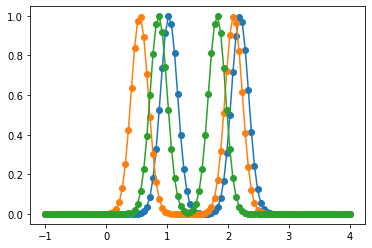

In [7]:
n_samples = 3

fd = make_multimodal_samples(n_samples=n_samples, n_modes=2, stop=4, random_state=1)
#fd.plot()

plt.plot(fd.grid_points[0], fd.data_matrix[:,:,0].T, "-o");

## Registration

### skfda

From ```https://fda.readthedocs.io/en/stable/_modules/skfda/preprocessing/registration/elastic.html#ElasticRegistration```

Align a FDatagrid using the SRSF framework.

Let :$f$ be a function of the functional data object wich will be
aligned to the template $g$. 

Calculates the warping wich minimises
the Fisher-Rao distance between $g$ and the registered function
$f^*(t)=f(\gamma^*(t))=f \circ \gamma^*$.

$$\gamma^* = argmin_{\gamma \in \Gamma} d_{\lambda}(f \circ\gamma, g)$$

Where $d_{\lambda}$ denotes the extended Fisher-Rao distance with a
penalty term, used to control the amount of warping.


$$d_{\lambda}^2(f \circ \gamma, g) = \| SRSF(f \circ \gamma)
\sqrt{\dot{\gamma}} - SRSF(g)\|_{\mathbb{L}^2}^2 + \lambda
\mathcal{R}(\gamma)$$

In the implementation it is used as penalty term

$$\mathcal{R}(\gamma) = \|\sqrt{\dot{\gamma}}- 1 \|_{\mathbb{L}^2}^2$$

Wich restrict the amount of elasticity employed in the alignment.

The registered function $f^*(t)$ can be calculated using the
composition $$f^*(t)=f(\gamma^*(t))$$.

If the template is not specified it is used the Karcher mean of the set of
functions under the elastic metric to perform the alignment, also known as
$elastic mean$, wich is the local minimum of the sum of squares of elastic
distances. See :func:$~elastic_mean$.

In :footcite:$srivastava+klassen_2016_analysis_elastic$ are described
extensively the algorithms employed and the SRSF framework.

In [8]:
# registration 

elastic_registration = ElasticRegistration()
fd_align = elastic_registration.fit_transform(fd)

# getting mean function
fd_mean         = fd.mean()
fd_elastic_mean = elastic_mean(fd)
fd_elastic_mean_y =fd_elastic_mean.data_matrix[:,:,0].ravel()

# getting data points
y_original = np.copy(fd.data_matrix[:,:,0].T)
y_new      = np.copy(fd_align.data_matrix[:,:,0].T)


# getting time points
t       = np.copy(fd.grid_points[0]) # original time points
gamma_t = np.copy(elastic_registration.warping_.data_matrix[:,:,0]).T # new evalution time points

# getting shifted time points (alignment by hand, or as "towers")
from scipy.interpolate import CubicSpline
fun_gamma_inv = [CubicSpline(gamma_t[:,i], t) for i in range(3)]
t_shifted = np.array( [fun_gamma_inv[i](t) for i in range(3)]).T


# Sanity check | time points
print("- Time points of elastic mean and f are the same:",
      (fd_elastic_mean.grid_points[0] == fd.grid_points[0]).all())

print("- Time points of f and f* are the same:",
      (fd_align.grid_points[0] == fd.grid_points[0]).all())

print("- Time points of $\gamma$ and f* are the same:",
      (elastic_registration.warping_.grid_points[0] == fd.grid_points[0]).all())

- Time points of elastic mean and f are the same: True
- Time points of f and f* are the same: True
- Time points of $\gamma$ and f* are the same: True


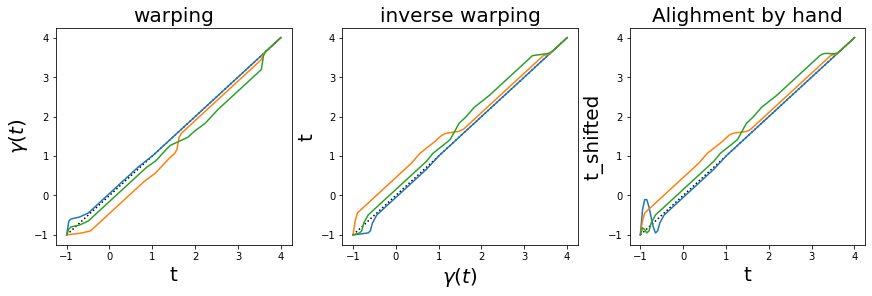

In [9]:
# warping 

fig, axes = plt.subplots(1,3,figsize=(12,4), constrained_layout=True)
t0, tf = t.min(), t.max()

for ax in axes:
    ax.plot([t0,tf], [t0,tf], ":k")
    
    i=0
axes[i].set_title("warping", fontsize=20)
axes[i].plot(t,gamma_t);
#axes[i].plot(t,gamma_t, ".");
axes[i].set_xlabel("t", fontsize=20)
axes[i].set_ylabel("$\gamma(t)$", fontsize=20)

i+=1
axes[i].set_title("inverse warping", fontsize=20)
axes[i].plot(gamma_t, t);
#axes[i].plot(gamma_t, t, ".");
axes[i].set_xlabel("$\gamma(t)$", fontsize=20)
axes[i].set_ylabel("t", fontsize=20);


i+=1
axes[i].set_title("Alighment by hand", fontsize=20)
axes[i].plot(t, t_shifted);
#axes[i].plot(t, t_shifted, ".");
axes[i].set_xlabel("t", fontsize=20)
axes[i].set_ylabel("t_shifted", fontsize=20);



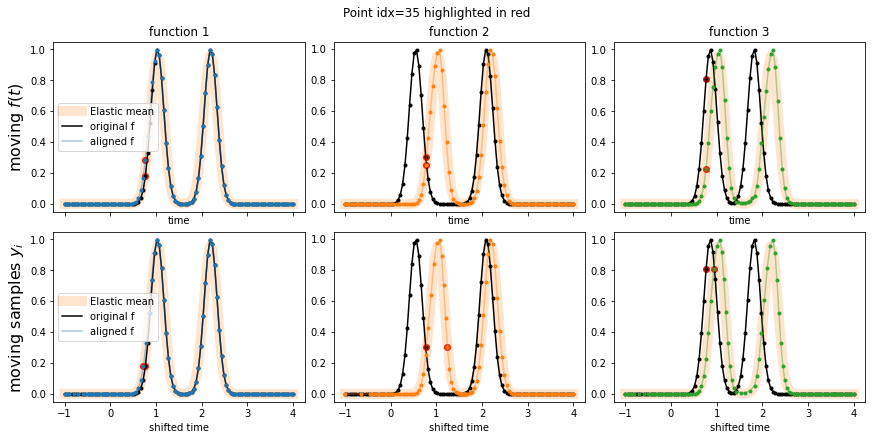

In [22]:
# registration 


fig, axes = plt.subplots(2,3,figsize=(12,6), constrained_layout=True, sharex=True)
axes=axes.ravel()

idx=35

# registration by moving the function
for i in range(3):
    axes[i].set_title("function %i"%(i+1));
    axes[i].plot(t, fd_elastic_mean_y, "C1", label="Elastic mean", alpha=0.2, lw=10);
    axes[i].plot(t, y_original[:,i], 'k', label="original f");
    axes[i].plot(t, y_original[:,i], ".k");
    axes[i].scatter(t[idx], y_original[idx,i], c="r");

    axes[i].plot(t, y_new[:,i], ".C%i"%i);
    axes[i].plot(t, y_new[:,i], "C%i"%i, alpha=0.4, label="aligned f");
    axes[i].scatter(t[idx], y_new[idx,i], c="r");
    
    
# registration by moving the original data points
for i in range(3):
    axes[i+3].plot(t, fd_elastic_mean_y, "C1", label="Elastic mean", alpha=0.2, lw=10);
    axes[i+3].plot(t, y_original[:,i], 'k', label="original f");
    axes[i+3].plot(t, y_original[:,i], ".k");
    axes[i+3].scatter(t[idx], y_original[idx,i], c="r");

    axes[i+3].plot(t_shifted[:,i], y_original[:,i], ".C%i"%i);
    axes[i+3].plot(t_shifted[:,i], y_original[:,i], "C%i"%i, alpha=0.4, label="aligned f");
    axes[i+3].scatter(t_shifted[idx,i], y_original[idx,i], c="r");

i=0
for ax in axes:
    if i<3:
        ax.set_xlabel("time")
    else:
        ax.set_xlabel("shifted time")
    i+=1
    
    
axes[0].legend()
axes[3].legend()

axes[0].set_ylabel("moving $f(t)$", fontsize=16)
axes[3].set_ylabel("moving samples $y_i$", fontsize=16);

fig.suptitle("Point idx=%i highlighted in red"%idx);

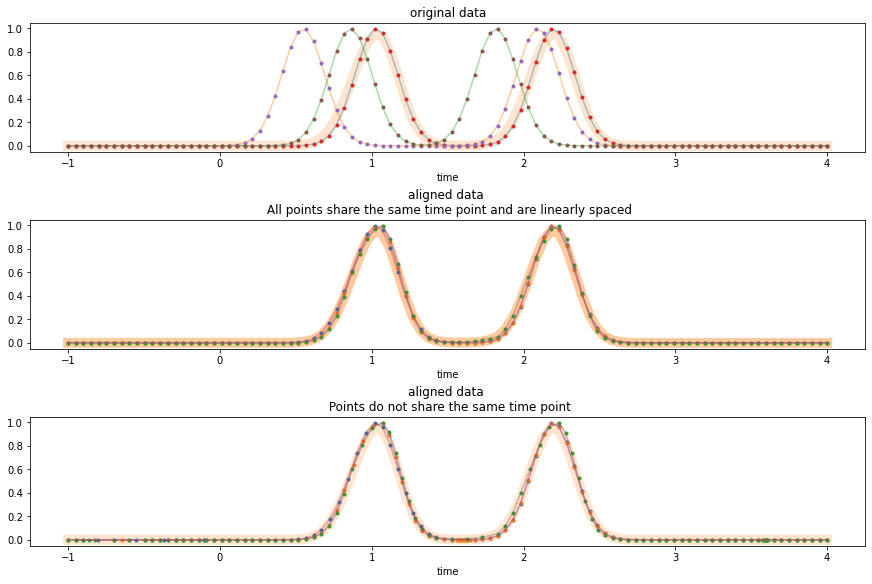

In [11]:
# plotting


fig, axes = plt.subplots(3,1,figsize=(12,8), constrained_layout=True)

i=0
axes[i].set_title("original data");
axes[i].plot(t, fd_elastic_mean_y, "C1", label="Elastic mean", alpha=0.2, lw=10);
axes[i].plot(t, y_original, alpha=0.4);
axes[i].plot(t, y_original, ".");

i+=1
axes[i].plot(t, fd_elastic_mean_y, "C1", label="Elastic mean", alpha=0.4, lw=10);
axes[i].set_title("aligned data \n All points share the same time point and are linearly spaced");
axes[i].plot(t, y_new, ".");
axes[i].plot(t, y_new, alpha=0.4);



i+=1
axes[i].plot(t, fd_elastic_mean_y, "C1", label="Elastic mean", alpha=0.2, lw=10);
axes[i].set_title("aligned data \n Points do not share the same time point");
axes[i].plot(t_shifted, y_original, ".");
axes[i].plot(t_shifted, y_original, alpha=0.4);

for ax in axes:
    ax.set_xlabel("time")

## BKP

In [43]:
def get_idx_nearest_value(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [46]:
i=1
y_ref = np.copy(fd.data_matrix[i,idx,0])
idx_ref = get_idx_nearest_value(fd_align.data_matrix[i,:,0], y_ref)

In [ ]:
idx = 28


y_ref = np.copy(fd.data_matrix[i,idx,0])
    idx_ref = get_idx_nearest_value(fd_align.data_matrix[i,:,0], y_ref)
    axes[i].scatter(t[idx], fd.data_matrix[i,idx,0], c="r");
    axes[i].scatter(t[idx_ref], fd_align.data_matrix[i,idx_ref,0], c="b");

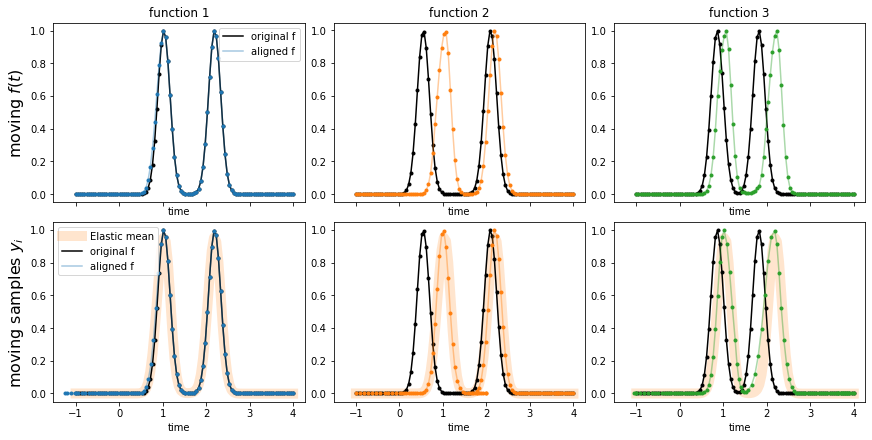

In [49]:
# registration 

elastic_registration = ElasticRegistration()

fd_align = elastic_registration.fit_transform(fd)


fig, axes = plt.subplots(2,3,figsize=(12,6), constrained_layout=True, sharex=True)
axes=axes.ravel()

idx=28

# registration by moving the function
for i in range(3):
    axes[i].set_title("function %i"%(i+1));
    axes[i].plot(t, fd.data_matrix[i,:,0].T, 'k', label="original f");
    axes[i].plot(t, fd.data_matrix[i,:,0].T, ".k");

    axes[i].plot(t, fd_align.data_matrix[i,:,0].T, ".C%i"%i);
    axes[i].plot(t, fd_align.data_matrix[i,:,0].T, "C%i"%i, alpha=0.4, label="aligned f");
    
    
# registration by moving the original data points
for i in range(3):
    axes[i+3].plot(t, fd_elastic_mean_y, "C1", label="Elastic mean", alpha=0.2, lw=10);
    axes[i+3].plot(t, fd.data_matrix[i,:,0].T, 'k', label="original f");
    axes[i+3].plot(t, fd.data_matrix[i,:,0].T, ".k");

    axes[i+3].plot(t_by_hand[i,:], fd.data_matrix[i,:,0].T, ".C%i"%i);
    axes[i+3].plot(t_by_hand[i,:], fd.data_matrix[i,:,0].T, "C%i"%i, alpha=0.4, label="aligned f");

for ax in axes:
    ax.set_xlabel("time")
    
    
axes[0].legend()
axes[3].legend()

axes[0].set_ylabel("moving $f(t)$", fontsize=16)
axes[3].set_ylabel("moving samples $y_i$", fontsize=16);

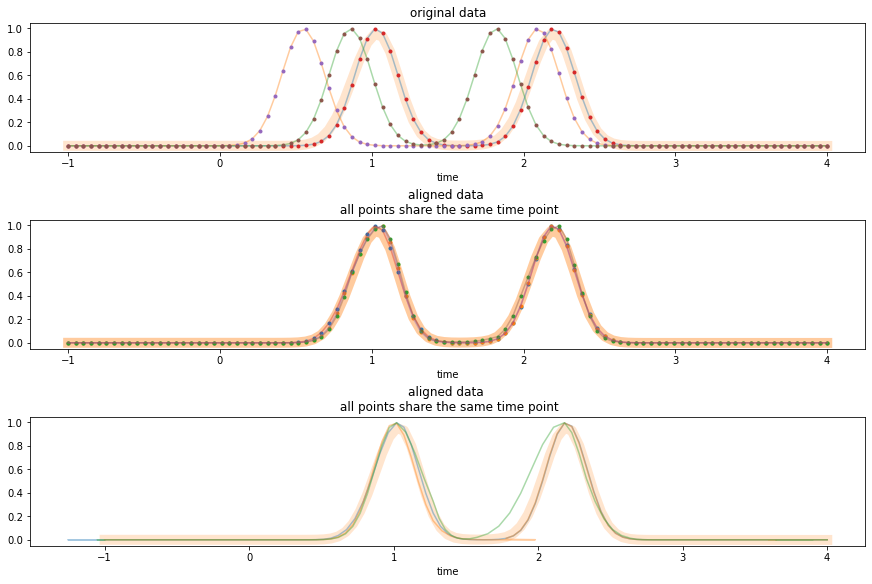

In [17]:
# plotting


fig, axes = plt.subplots(3,1,figsize=(12,8), constrained_layout=True)

i=0
axes[i].set_title("original data");
axes[i].plot(t, fd_elastic_mean_y, "C1", label="Elastic mean", alpha=0.2, lw=10);
axes[i].plot(t, fd.data_matrix[:,:,0].T, alpha=0.4);
axes[i].plot(t, fd.data_matrix[:,:,0].T, ".");

i+=1
axes[i].plot(t, fd_elastic_mean_y, "C1", label="Elastic mean", alpha=0.4, lw=10);
axes[i].set_title("aligned data \n all points share the same time point");
axes[i].plot(t, fd_align.data_matrix[:,:,0].T, ".");
axes[i].plot(t, fd_align.data_matrix[:,:,0].T, alpha=0.4);



i+=1
axes[i].plot(t, fd_elastic_mean_y, "C1", label="Elastic mean", alpha=0.2, lw=10);
axes[i].set_title("aligned data \n all points share the same time point");
#axes[i].plot(t_by_hand.T, fd.data_matrix[:,:,0].T, ".");
axes[i].plot(t_by_hand.T, fd.data_matrix[:,:,0].T, alpha=0.4);

for ax in axes:
    ax.set_xlabel("time")